# Hand Gesture Recognition

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from scipy.fft import fft, fftfreq

In [2]:
from enum import IntEnum


base_dir = '../recordings/'
num_classes = 7
class Classes(IntEnum):
    NEUTRAL = 0,
    FIST = 1,
    INDEX = 2,
    MIDDLE = 3,
    OK = 4,
    PEACE = 5,
    THUMB = 6
    
# structure: recordings/date/data/*.csv
files = [[] for _ in range(num_classes)]

for date_dir, _, filenames in os.walk(base_dir):
    if date_dir.endswith('data'):
        for filename in filenames:
            if filename.startswith('fft'):
                continue
            if filename.find('neutral') != -1:
                files[Classes.NEUTRAL].append(os.path.join(date_dir, filename))
            elif filename.find('fist') != -1:
                files[Classes.FIST].append(os.path.join(date_dir, filename))
            elif filename.find('index') != -1:
                files[Classes.INDEX].append(os.path.join(date_dir, filename))
            elif filename.find('middle') != -1:
                files[Classes.MIDDLE].append(os.path.join(date_dir, filename))
            elif filename.find('ok') != -1:
                files[Classes.OK].append(os.path.join(date_dir, filename))
            elif filename.find('peace') != -1:
                files[Classes.PEACE].append(os.path.join(date_dir, filename))
            elif filename.find('thumb') != -1:
                files[Classes.THUMB].append(os.path.join(date_dir, filename))

print(files)      

[['../recordings/02_12_24/data/gilbert_neutral_0.csv', '../recordings/05_12_24/data/luka_neutral_0.csv', '../recordings/05_12_24/data/teacher_neutral_0.csv', '../recordings/01_12_24_initial_placement_test/data/gilbert_neutral_0.csv', '../recordings/01_12_24_initial_placement_test/data/nad_neutral_0.csv'], ['../recordings/02_12_24/data/gilbert_fist_0.csv', '../recordings/05_12_24/data/teacher_fist_0.csv', '../recordings/05_12_24/data/luka_fist_0.csv', '../recordings/01_12_24_initial_placement_test/data/gilbert_fist_0.csv', '../recordings/01_12_24_initial_placement_test/data/nad_fist_0.csv'], ['../recordings/02_12_24/data/gilbert_index_0.csv', '../recordings/05_12_24/data/luka_index_0.csv', '../recordings/05_12_24/data/teacher_index_0.csv', '../recordings/01_12_24_initial_placement_test/data/gilbert_index_0.csv', '../recordings/01_12_24_initial_placement_test/data/nad_index_0.csv'], ['../recordings/05_12_24/data/luka_middle_0.csv', '../recordings/05_12_24/data/teacher_middle_0.csv', '../

Our initial static gesture recording includes 7 classes: neutral, fist, index finger, middle finger, ok, peace, thumb.

In [3]:
neutral_df = [pd.read_csv(file, header=None) for file in files[Classes.NEUTRAL]]
fist_df = [pd.read_csv(file, header=None) for file in files[Classes.FIST]]
index_df = [pd.read_csv(file, header=None) for file in files[Classes.INDEX]]
middle_df = [pd.read_csv(file, header=None) for file in files[Classes.MIDDLE]]
ok_df = [pd.read_csv(file, header=None) for file in files[Classes.OK]]
peace_df = [pd.read_csv(file, header=None) for file in files[Classes.PEACE]]
thumb_df = [pd.read_csv(file, header=None) for file in files[Classes.THUMB]]

In [4]:
for df in neutral_df:
    df['class'] = Classes.NEUTRAL
for df in fist_df:
    df['class'] = Classes.FIST
for df in index_df:
    df['class'] = Classes.INDEX
for df in middle_df:
    df['class'] = Classes.MIDDLE
for df in ok_df:
    df['class'] = Classes.OK
for df in peace_df:
    df['class'] = Classes.PEACE
for df in thumb_df:
    df['class'] = Classes.THUMB

In [5]:
len(neutral_df), len(fist_df), len(index_df), len(middle_df), len(ok_df), len(peace_df), len(thumb_df)

def print_min_df_len(dfs):
    min_len = min([len(df_) for df in dfs for df_ in df])
    return min_len

min_len = print_min_df_len([neutral_df, fist_df, index_df, middle_df, ok_df, peace_df, thumb_df])
print(min_len)

6547


Optional subsampling:

In [6]:
num_samples = min_len

neutral_df = pd.concat([df.sample(num_samples) for df in neutral_df])
fist_df = pd.concat([df.sample(num_samples) for df in fist_df])
index_df = pd.concat([df.sample(num_samples) for df in index_df])
middle_df = pd.concat([df.sample(num_samples) for df in middle_df])
ok_df = pd.concat([df.sample(num_samples) for df in ok_df])
peace_df = pd.concat([df.sample(num_samples) for df in peace_df])
thumb_df = pd.concat([df.sample(num_samples) for df in thumb_df])
# neutral_df = neutral_df[0].sample(num_samples)
# fist_df = fist_df[0].sample(num_samples)
# index_df = index_df[0].sample(num_samples)
# middle_df = middle_df[0].sample(num_samples)
# ok_df = ok_df[0].sample(num_samples)
# peace_df = peace_df[0].sample(num_samples)
# thumb_df = thumb_df[0].sample(num_samples)

In [7]:
len(neutral_df), len(fist_df), len(index_df), len(middle_df), len(ok_df), len(peace_df), len(thumb_df)

(32735, 32735, 32735, 26188, 26188, 26188, 26188)

In [8]:
neutral_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,class
1555,17407,17410,17434,17434,17432,17395,17375,17368,18390,18373,...,18013,18623,18470,18454,18464,18520,18534,18540,18584,0
12413,17608,17615,17599,17560,17530,17519,17539,17530,18354,18395,...,18119,18527,18493,18504,18539,18555,18517,18484,18453,0
4855,18358,18384,18375,18320,18266,18259,18301,18311,18162,18191,...,17557,17984,17972,17976,18042,18124,18173,18190,18199,0
2015,17222,17228,17229,17209,17227,17234,17218,17163,18479,18486,...,17535,18217,18232,18220,18197,18174,18132,18140,18137,0
6287,17291,17282,17278,17232,17183,17177,17179,17217,18465,18523,...,18171,18555,18548,18512,18494,18541,18544,18518,18478,0


In [9]:
fist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,class
2822,17275,17267,17239,17219,17204,17200,17196,17182,18287,18309,...,18557,18337,18271,18210,18242,18230,18248,18297,18286,1
2322,17425,17740,17930,18012,18183,18150,18112,18222,18548,18558,...,17508,18164,18182,18195,18185,18177,18228,18250,18218,1
2700,18529,18543,18599,18668,18638,18574,18540,18498,18305,18299,...,17569,17671,17723,17709,17694,17707,17682,17727,17785,1
1677,17596,17374,17007,17227,17280,16812,17038,17670,17902,17938,...,18118,18020,17909,17806,17973,18023,17947,17855,17839,1
8007,18949,18920,18211,18275,18416,18390,17914,18117,18119,18092,...,17952,17474,17519,17588,17560,17476,17579,17628,17621,1


Combine dataframes

In [10]:
df = pd.concat([neutral_df, fist_df, index_df, middle_df, ok_df, peace_df, thumb_df], ignore_index=True)

print(df.head())
print(df.iloc[:, -1].value_counts())

       0      1      2      3      4      5      6      7      8      9  ...  \
0  17407  17410  17434  17434  17432  17395  17375  17368  18390  18373  ...   
1  17608  17615  17599  17560  17530  17519  17539  17530  18354  18395  ...   
2  18358  18384  18375  18320  18266  18259  18301  18311  18162  18191  ...   
3  17222  17228  17229  17209  17227  17234  17218  17163  18479  18486  ...   
4  17291  17282  17278  17232  17183  17177  17179  17217  18465  18523  ...   

      23     24     25     26     27     28     29     30     31  class  
0  18013  18623  18470  18454  18464  18520  18534  18540  18584      0  
1  18119  18527  18493  18504  18539  18555  18517  18484  18453      0  
2  17557  17984  17972  17976  18042  18124  18173  18190  18199      0  
3  17535  18217  18232  18220  18197  18174  18132  18140  18137      0  
4  18171  18555  18548  18512  18494  18541  18544  18518  18478      0  

[5 rows x 33 columns]
class
0    32735
1    32735
2    32735
3    26188
4 

In [11]:
sensor_data = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Data visualization

## Sensor signals

In [12]:
from scipy import signal
from scipy.signal import butter
from numpy import mean, std

lf = 15
hf = 400
fs = 1150
trim = 4*8*5
bandpass_order = 4
outlier_rejection_stds = 6

def _remove_outliers(data):
    data_mean, data_std = mean(data.flatten()), std(data.flatten())
    cut_off = data_std * outlier_rejection_stds
    lower, upper = data_mean - cut_off, data_mean + cut_off

    outliers_removed = [x if x >= lower and x <= upper else 0.0 for x in data]
    return outliers_removed

def _remove_artefact(data):
    data[:trim] = 0
    return data

def preprocess_data(data):
    sos = butter(bandpass_order, (lf, hf), btype="bandpass", fs=fs, output="sos")
    proc_data = signal.sosfilt(sos, data) # f
    proc_data = _remove_artefact(proc_data)
    # proc_data = _remove_outliers(proc_data)
    return proc_data


plot_all_timeline = False
num_sensors = 4

def plot_time_signals(dataframe, row_index, title):
    row_data = dataframe.iloc[row_index, :-1]

    # Split the row into 8 groups corresponding to sensors
    signals = np.array_split(row_data.values, num_sensors)

    # Plot each sensor's signal
    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(signals):
        plt.plot(signal, label=f'Sensor {i + 1}')
    
    plt.title(f"{title} (Row {row_index})")
    plt.xlabel("Time Steps")
    plt.ylabel("Signal Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_time_signals(dataframe, title):    
    all_row_data = dataframe.iloc[:, :-1]
    # Plot each sensor's signal
    signals = np.array_split(all_row_data.values, num_sensors)
    fig, axs = plt.subplots(2, 2, figsize=(24, 16))
    axs = axs.flatten()
    for sensor in range(0, num_sensors):
        sigs = signals[sensor]
        sigs = np.array(sigs).flatten()
        axs[sensor].set_title(f'Sensor {sensor + 1}')
        axs[sensor].plot(sigs)
    fig.suptitle(title)
    
    plt.show()


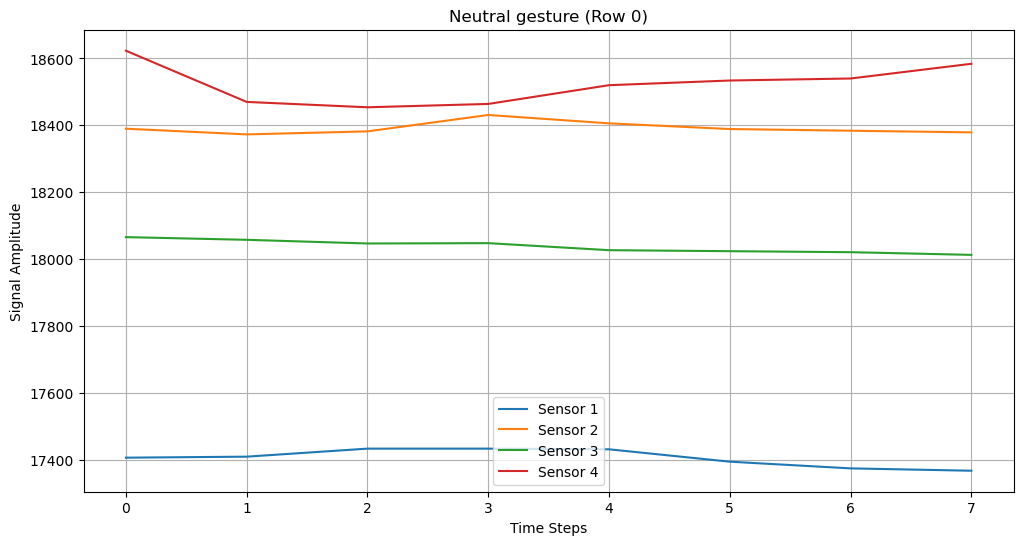

In [13]:
plot_time_signals(neutral_df, row_index=0, title='Neutral gesture')

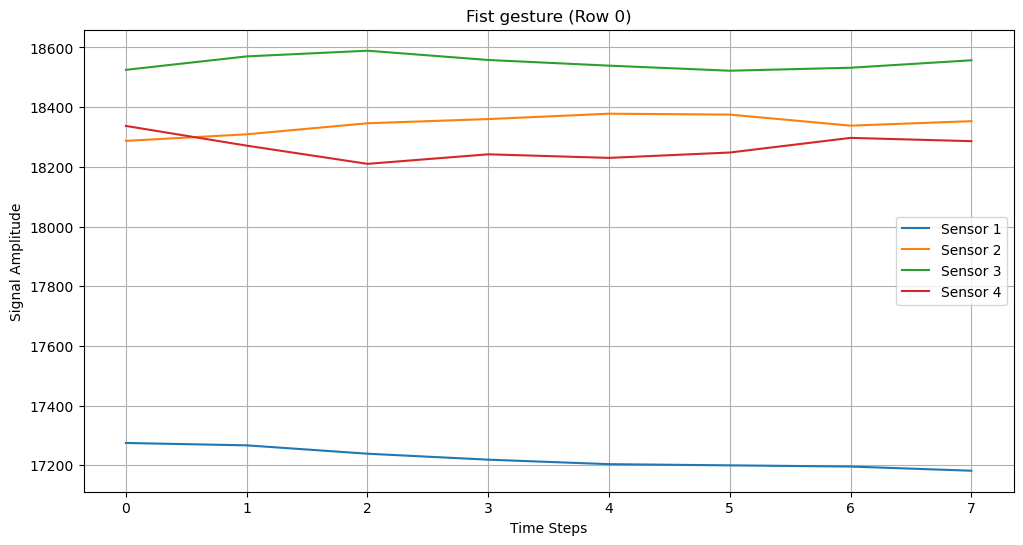

In [14]:
plot_time_signals(fist_df, row_index=0, title='Fist gesture')

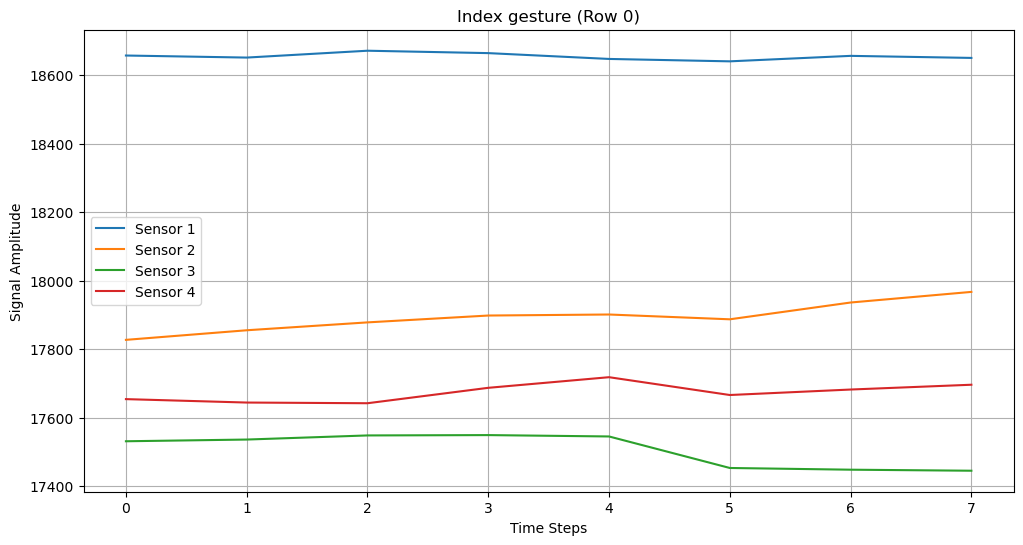

In [15]:
plot_time_signals(index_df, row_index=0, title='Index gesture')

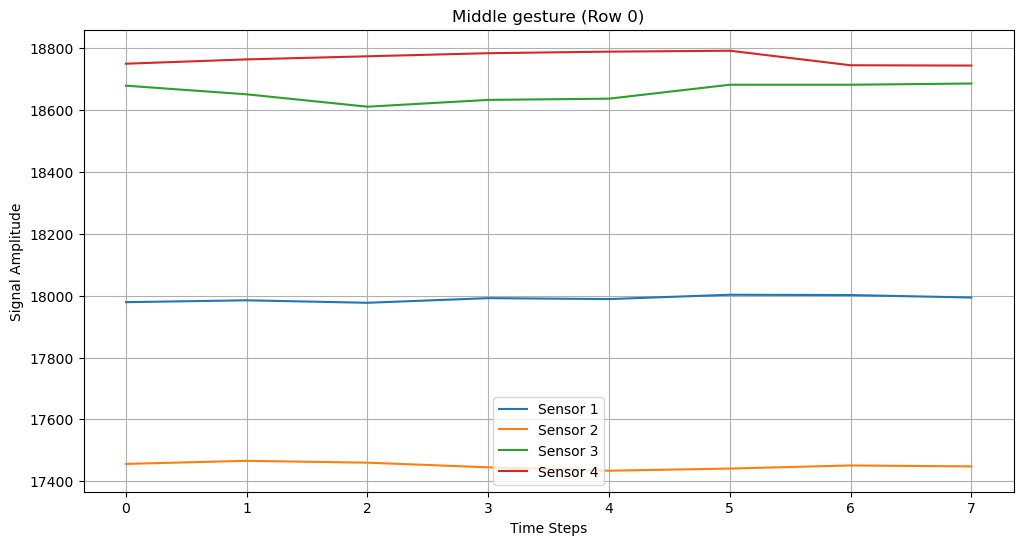

In [16]:
plot_time_signals(middle_df, row_index=0, title='Middle gesture')

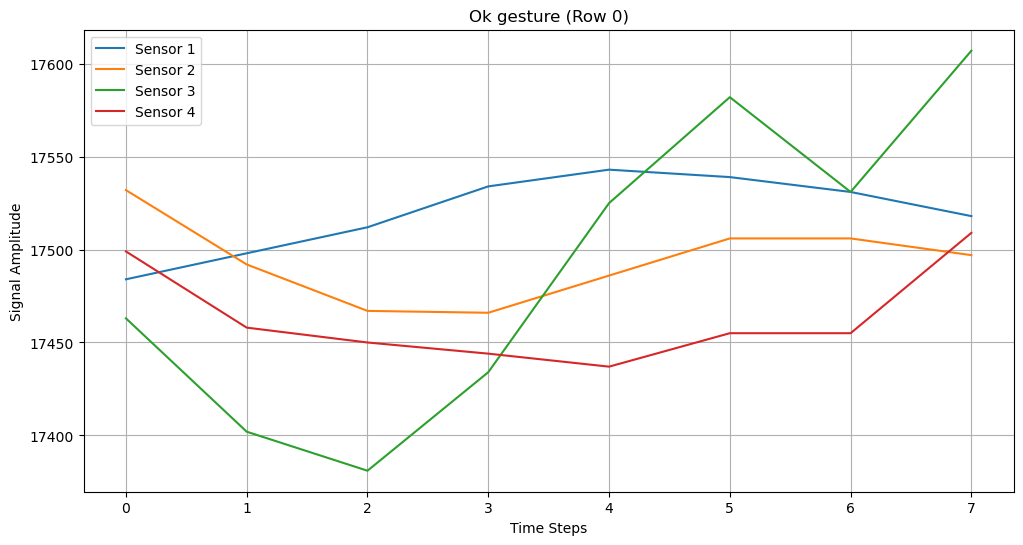

In [17]:
plot_time_signals(ok_df, row_index=0, title='Ok gesture')

In [18]:
if plot_all_timeline:
    plot_all_time_signals(neutral_df, title='Neutral gesture: whole timeline')
    plot_all_time_signals(fist_df, title='Fist gesture: whole timeline')
    plot_all_time_signals(peace_df, title='Peace gesture: whole timeline')
    plot_all_time_signals(ok_df, title='Ok gesture: whole timeline')
    plot_all_time_signals(index_df, title='Index gesture: whole timeline')
    plot_all_time_signals(middle_df, title='Middle gesture: whole timeline')

## Class distribution

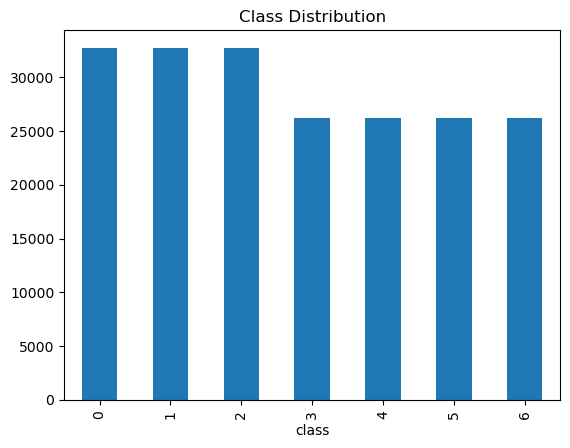

In [19]:
df.iloc[:, -1].value_counts().plot(kind='bar', title="Class Distribution")
plt.show()

## Sensor correlation analysis

/tmp/ipykernel_48588/515862046.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sensor_means = sensor_data.groupby(np.arange(sensor_data.shape[1]) // 8, axis=1).mean()


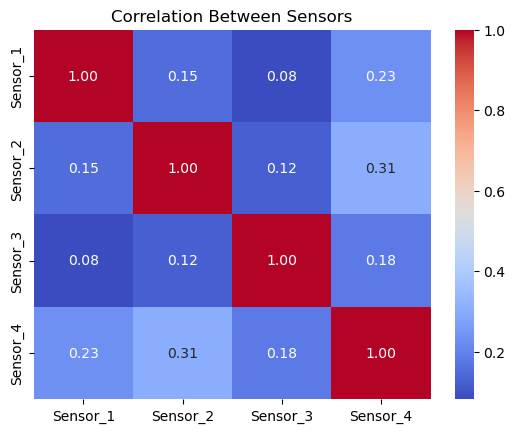

In [20]:
sensor_means = sensor_data.groupby(np.arange(sensor_data.shape[1]) // 8, axis=1).mean()

sensor_means.columns = [f"Sensor_{i+1}" for i in range(4)]

correlation = sensor_means.corr()

sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Sensors")
plt.show()

In [21]:
from scipy import signal
from scipy.signal import butter
from numpy import mean, std

lf = 15
hf = 400
fs = 1150
trim = 4*8*5
bandpass_order = 3
outlier_rejection_stds = 6

def _remove_outliers(data):
    data_mean, data_std = mean(data.flatten()), std(data.flatten())
    cut_off = data_std * outlier_rejection_stds
    lower, upper = data_mean - cut_off, data_mean + cut_off

    outliers_removed = [x if x >= lower and x <= upper else 0.0 for x in data]
    return outliers_removed

def _remove_artefact(data):
    data[:trim] = 0
    return data

def preprocess_data(data):
    sos = butter(bandpass_order, (lf, hf), btype="bandpass", fs=fs, output="sos")
    proc_data = signal.sosfilt(sos, data) # f
    return proc_data


## Dimensionality Reduction

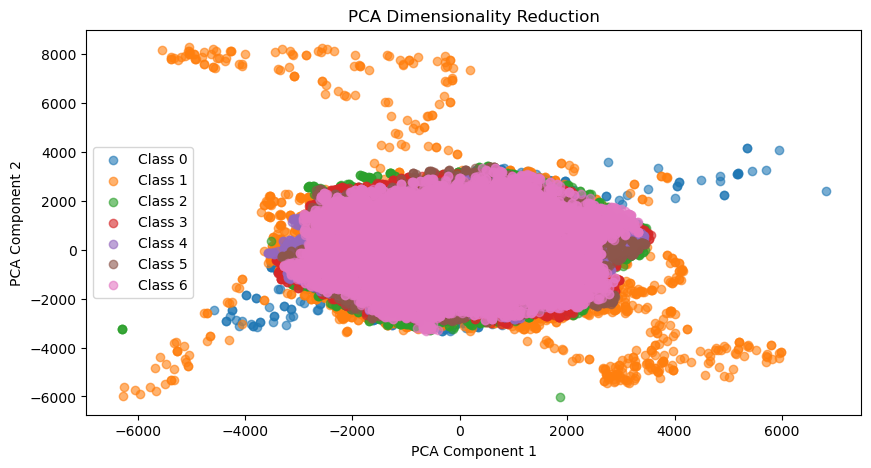

/home/madnad/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


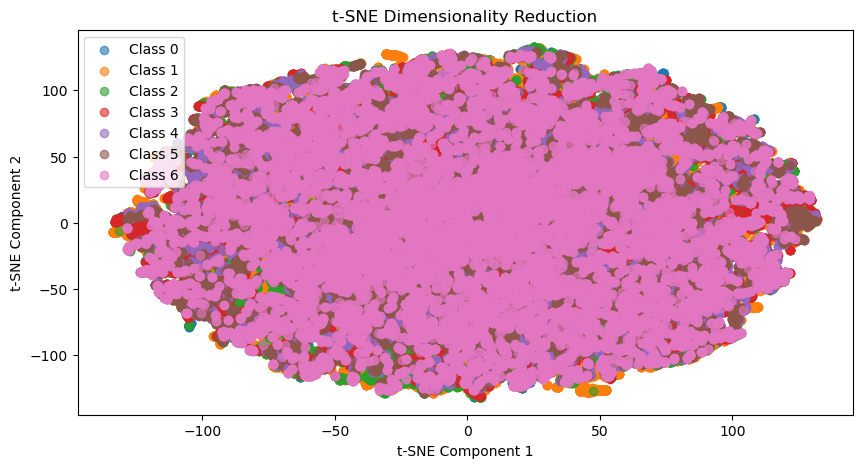

In [22]:
# PCA Dimensionality Reduction to 2 components
pca = PCA(n_components=2)
sensor_preproc = preprocess_data(sensor_data)
pca_result = pca.fit_transform(sensor_preproc)

# Plot PCA results
plt.figure(figsize=(10, 5))
for class_id in np.unique(labels):
    plt.scatter(pca_result[labels == class_id, 0], pca_result[labels == class_id, 1], label=f'Class {class_id}', alpha=0.6)
plt.title("PCA Dimensionality Reduction")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# t-SNE Dimensionality Reduction to 2 components
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(sensor_preproc)

# Plot t-SNE results
plt.figure(figsize=(10, 5))
for class_id in np.unique(labels):
    plt.scatter(tsne_result[labels == class_id, 0], tsne_result[labels == class_id, 1], label=f'Class {class_id}', alpha=0.6)
plt.title("t-SNE Dimensionality Reduction")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

## Data Preprocessing

## Spectal Analysis

In [23]:
preprocess = True

def spectral_analysis_overall(dataframe):
    time_steps_per_sensor = dataframe.shape[1] // num_sensors

    # Separate gesture class and sensor data
    gesture_classes = dataframe.iloc[:, -1]
    sensor_data = dataframe.iloc[:, :-1]
    
    # Prepare to store FFT results for each sensor
    fft_results = {f'Sensor_{i+1}': [] for i in range(num_sensors)}

    # Loop over all rows and accumulate FFT results per sensor
    for index, row in sensor_data.iterrows():
        signals = np.array_split(row.values, num_sensors)
        for i, signal in enumerate(signals):
            if preprocess:
                signal = preprocess_data(signal)
            fft_result = np.abs(fft(signal))[:time_steps_per_sensor // 2]  # Positive frequencies only
            fft_results[f'Sensor_{i+1}'].append(fft_result)
    
    # Compute average FFT amplitude for each sensor
    avg_fft_results = {sensor: np.mean(fft_results[sensor], axis=0) for sensor in fft_results}

    # Plot average FFT for each sensor
    plt.figure(figsize=(15, 10))
    for sensor, avg_fft in avg_fft_results.items():
        freqs = fftfreq(time_steps_per_sensor, d=1/fs)[:time_steps_per_sensor // 2]  # Positive frequencies
        plt.plot(freqs, avg_fft, label=sensor)
    
    plt.title("Average Spectral Analysis for All Sensors")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Now analyze by gesture class
    unique_classes = np.unique(gesture_classes)
    plt.figure(figsize=(15, 10))
    for gesture_class in unique_classes:
        class_subset = dataframe[dataframe.iloc[:, -1] == gesture_class]
        class_fft_results = {f'Sensor_{i+1}': [] for i in range(num_sensors)}
        for _, row in class_subset.iloc[:, :-1].iterrows():
            signals = np.array_split(row.values, num_sensors)
            for i, signal in enumerate(signals):
                if preprocess:
                    signal = preprocess_data(signal)
                fft_result = np.abs(fft(signal))[:time_steps_per_sensor // 2]
                class_fft_results[f'Sensor_{i+1}'].append(fft_result)
        # Average across this class
        avg_class_fft = np.mean([np.mean(class_fft_results[sensor], axis=0) for sensor in class_fft_results], axis=0)
        freqs = fftfreq(time_steps_per_sensor, d=1/fs)[:time_steps_per_sensor // 2]
        plt.plot(freqs, avg_class_fft, label=f"Class {gesture_class}")

    plt.title("Average Spectral Analysis by Gesture Class")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

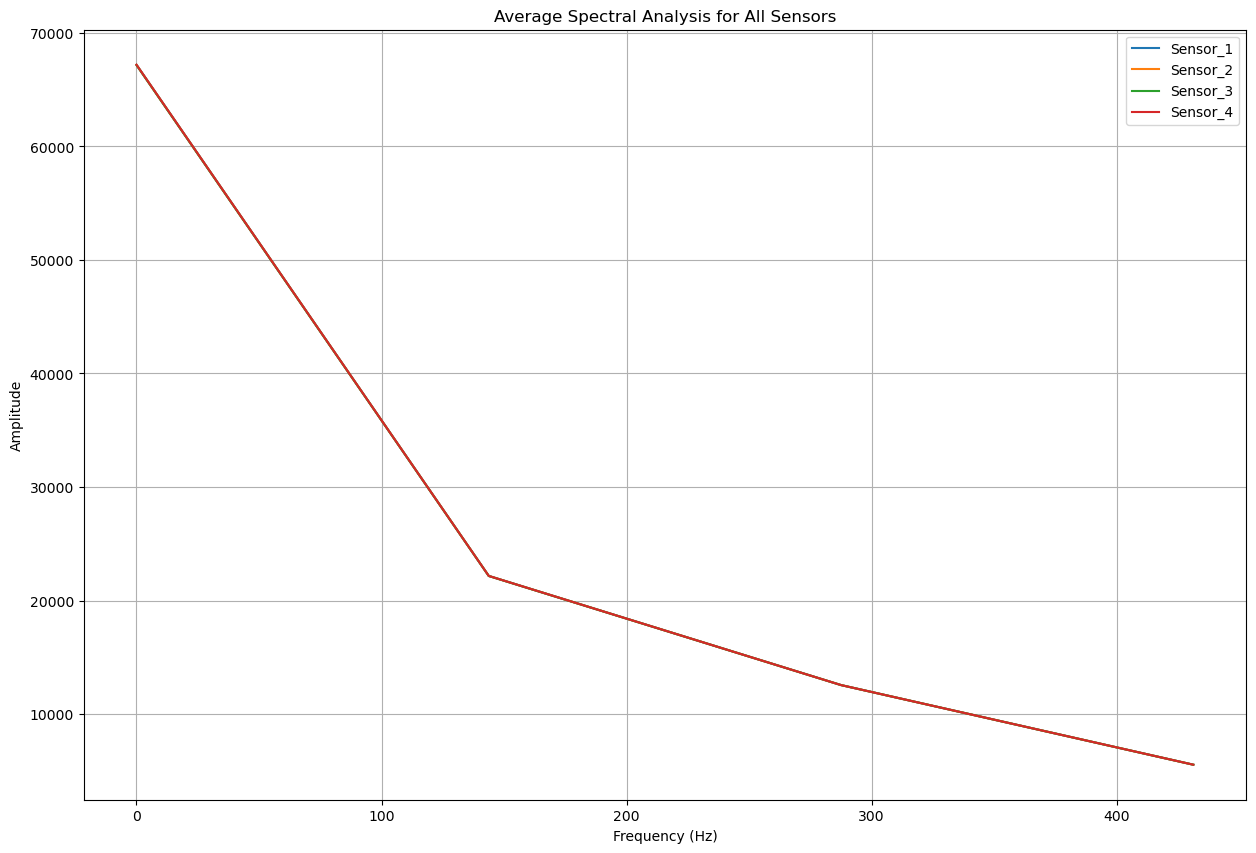

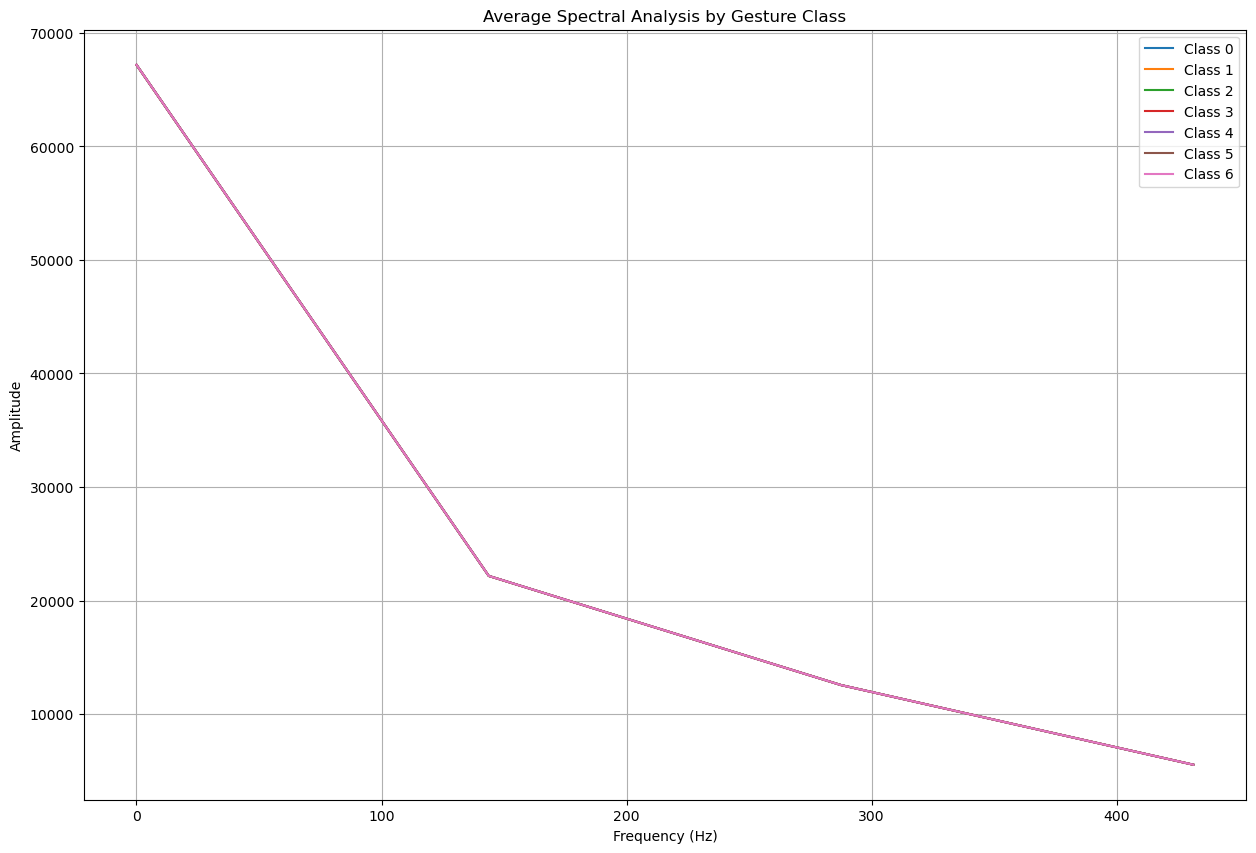

In [24]:
spectral_analysis_overall(df)

## Train networks

In [25]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [26]:
X = preprocess_data(X)

In [27]:
X.max(), X.min()

(19853.200808531146, -9196.711777552942)

In [28]:
# from sklearn.preprocessing import RobustScaler
# scaler= RobustScaler()
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [29]:
from pickle import dump
with open("custom_scaler.pkl", "wb") as f:
    dump(scaler, f, protocol=5)

In [30]:
X.max(), X.min()

(20.740252947815648, -32.86477322858651)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [32]:
# Count classes in y_test
unique, counts = np.unique(y_test, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6]),
 array([6518, 6522, 6493, 5206, 5236, 5380, 5237]))

## Classical models

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
from pickle import dump
with open("custom_classifier_gen2.pkl", "wb") as f:
    dump(clf, f, protocol=5)

In [35]:
y_pred = clf.predict(X_test)

In [36]:
print('Classification Report: \n', classification_report(y_test,y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test,y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      6518
           1       0.97      0.94      0.95      6522
           2       0.93      0.94      0.94      6493
           3       0.95      0.95      0.95      5206
           4       0.95      0.95      0.95      5236
           5       0.94      0.94      0.94      5380
           6       0.96      0.93      0.94      5237

    accuracy                           0.94     40592
   macro avg       0.94      0.94      0.94     40592
weighted avg       0.94      0.94      0.94     40592

Confusion Matrix: 
 [[6185   19  129   59   26   79   21]
 [ 107 6107   75   67   52   34   80]
 [ 168   44 6103   48   37   56   37]
 [  92   40   49 4944   28   36   17]
 [ 100   21   56   28 4952   51   28]
 [ 139   15   61   29   67 5039   30]
 [  92   62   71   46   35   55 4876]]


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

lr_grid = {'max_depth' : [4, 8, 16, 32, 64, 128],
           'criterion' : ['entropy', 'gini']}

clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)

gs = GridSearchCV(estimator=clf, param_grid=lr_grid, cv=5)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)

In [38]:
print('Classification Report: \n', classification_report(y_test,y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test,y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      6518
           1       0.97      0.94      0.96      6522
           2       0.94      0.94      0.94      6493
           3       0.95      0.95      0.95      5206
           4       0.95      0.95      0.95      5236
           5       0.95      0.94      0.94      5380
           6       0.96      0.93      0.94      5237

    accuracy                           0.94     40592
   macro avg       0.95      0.94      0.94     40592
weighted avg       0.94      0.94      0.94     40592

Confusion Matrix: 
 [[6198   22  113   65   23   75   22]
 [  90 6138   73   56   50   38   77]
 [ 180   35 6128   40   41   36   33]
 [  88   36   44 4966   25   26   21]
 [  91   12   52   34 4961   58   28]
 [ 144   15   45   30   66 5052   28]
 [ 105   56   62   52   38   49 4875]]


In [39]:
from pickle import dump
with open("custom_classifier_gen2.pkl", "wb") as f:
    dump(gs, f, protocol=5)

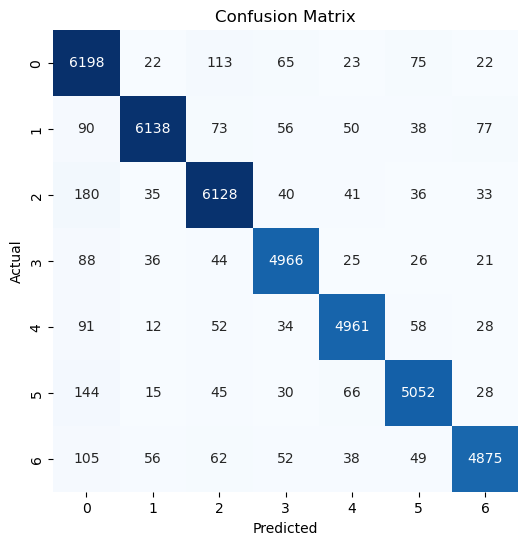

In [40]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Deep Learning

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(1024, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.softmax(self.fc3(x), dim=1)
        return x

In [43]:
input_size = X_train.shape[1]
output_size = 7
batch_size = 64
epochs = 200
learning_rate = 0.001

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNet(input_size, output_size)
criterion = nn.CrossEntropyLoss()  # Sparse categorical cross-entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NeuralNet(
  (fc1): Linear(in_features=32, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=1024, out_features=7, bias=True)
)

In [44]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step(running_loss / total)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/200, Loss: 1.8031, Accuracy: 34.34%
Epoch 2/200, Loss: 1.7396, Accuracy: 41.43%
Epoch 3/200, Loss: 1.7177, Accuracy: 43.66%
Epoch 4/200, Loss: 1.7060, Accuracy: 44.84%
Epoch 5/200, Loss: 1.6958, Accuracy: 45.99%
Epoch 6/200, Loss: 1.6880, Accuracy: 46.75%
Epoch 7/200, Loss: 1.6844, Accuracy: 47.20%
Epoch 8/200, Loss: 1.6780, Accuracy: 47.91%
Epoch 9/200, Loss: 1.6723, Accuracy: 48.44%
Epoch 10/200, Loss: 1.6693, Accuracy: 48.78%
Epoch 11/200, Loss: 1.6634, Accuracy: 49.50%
Epoch 12/200, Loss: 1.6607, Accuracy: 49.70%
Epoch 13/200, Loss: 1.6553, Accuracy: 50.22%
Epoch 14/200, Loss: 1.6515, Accuracy: 50.66%
Epoch 15/200, Loss: 1.6490, Accuracy: 50.95%
Epoch 16/200, Loss: 1.6481, Accuracy: 51.07%
Epoch 17/200, Loss: 1.6459, Accuracy: 51.30%
Epoch 18/200, Loss: 1.6431, Accuracy: 51.58%
Epoch 19/200, Loss: 1.6423, Accuracy: 51.70%
Epoch 20/200, Loss: 1.6393, Accuracy: 52.00%
Epoch 21/200, Loss: 1.6390, Accuracy: 52.05%
Epoch 22/200, Loss: 1.6351, Accuracy: 52.45%
Epoch 23/200, Loss:

In [45]:
torch.save(model.state_dict(), 'custom_nn_gen.pth')

In [46]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    outputs = model(X_test_tensor)
    _, predicted = outputs.max(1)
    test_accuracy = predicted.eq(y_test_tensor).sum().item() / y_test_tensor.size(0) * 100

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 69.05%


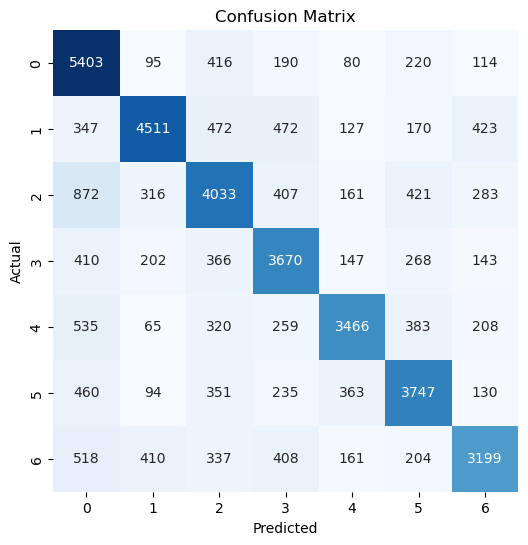

In [47]:
cm = confusion_matrix(y_test, predicted.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
class PureLSTM(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_sequence, n_layers, n_classes):
        super(PureLSTM, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        
        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=128)
        self.dropout_1 = nn.Dropout(p=0.2)
        
        self.linear_2 = nn.Linear(in_features=128, out_features=n_classes)        
        
    
    def forward(self, x):
        
        self.hidden = (
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device),
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device)
        )
    
        out, (hs, cs) = self.lstm(x.view(len(x), self.n_sequence, -1),self.hidden)
        out = out[:,-1,:]

        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)
        
        return out
    
def train_model(model, train_dataloader, n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    for epoch in range(n_epochs):
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             # Compute running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    scheduler.step(running_loss / total)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
    return model

In [52]:
n_features = 32
n_sequence=1
# n_features = 4
# n_sequence=8
n_hidden=32*3
n_layers=2
epochs = 400

model = PureLSTM(n_features, n_hidden, n_sequence, n_layers, output_size).to(device)

print("Train Data Shape ",X_train.shape, y_train.shape)
print("Test Data Shape ",X_test.shape, y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# X_train_tensor = X_train_tensor.view(-1, n_sequence, n_features)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model = train_model(model, train_loader, n_epochs = epochs)

Train Data Shape  (162365, 32) (162365,)
Test Data Shape  (40592, 32) (40592,)
Epoch 10 train loss: 1.2071670293807983
Epoch 20 train loss: 1.028162956237793
Epoch 30 train loss: 0.7635336518287659
Epoch 40 train loss: 0.834686279296875
Epoch 50 train loss: 0.7967258095741272
Epoch 60 train loss: 0.6134807467460632
Epoch 70 train loss: 0.7025626301765442
Epoch 80 train loss: 0.5114780068397522
Epoch 90 train loss: 0.6761643886566162
Epoch 100 train loss: 0.42287710309028625
Epoch 110 train loss: 0.6425116658210754
Epoch 120 train loss: 0.6664916276931763
Epoch 130 train loss: 0.7676233649253845
Epoch 140 train loss: 0.4911530613899231
Epoch 150 train loss: 0.4464700222015381
Epoch 160 train loss: 0.4891616702079773
Epoch 170 train loss: 0.6058960556983948
Epoch 180 train loss: 0.4718989431858063
Epoch 190 train loss: 0.6160635352134705
Epoch 200 train loss: 0.4115262031555176
Epoch 210 train loss: 0.6221463084220886
Epoch 220 train loss: 0.4207843840122223
Epoch 230 train loss: 0.35634

In [50]:
torch.save(model.state_dict(), 'custom_lstm_gen.pth')

def evaluateModel(outputs, y):
    _, predicted = outputs.max(1)
    test_accuracy = predicted.eq(y).sum().item() / y.size(0) * 100
    return test_accuracy, predicted

model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    y_hat_test = model(X_test_tensor)
    acc, predicted = evaluateModel(y_hat_test, y_test_tensor)
    print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 67.37%


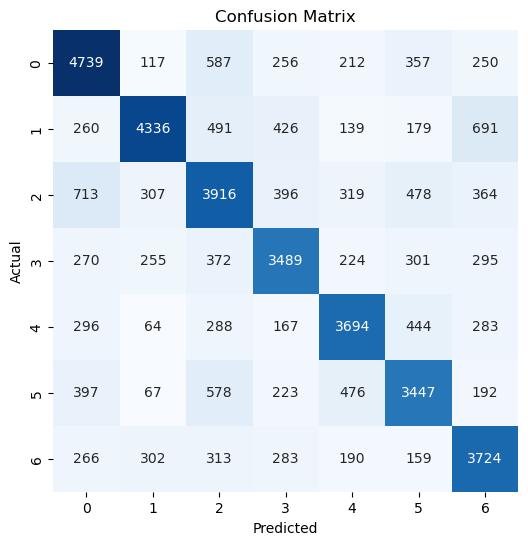

In [51]:
cm = confusion_matrix(y_test, predicted.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Feature engineering